In [92]:
# io文件操作
import re
import os
import glob
import shutil

# 数据操作
import numpy as np
from osgeo import gdal
from datetime import datetime

# 数据可视化
import matplotlib.pyplot as plt

## 1. Function of Normalization

In [93]:
def normalize(array_1d):
    mean = np.mean(array_1d, axis=0)
    std = np.std(array_1d, axis=0)
    return (array_1d - mean) / std

## 2. Verified Matrix to Show Valid Cells of SMAP TIFF

In [94]:
verified_mat = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         ])
verified_mat[0][2:7] = 1
verified_mat[1][0:8] = 1
verified_mat[2][0:10] = 1
verified_mat[3][0:12] = 1
verified_mat[4][2:13] = 1
verified_mat[5][6:13] = 1
verified_mat[6][7:12] = 1
print(verified_mat.shape)

(7, 13)


## 3. Function of TIFF to Numpy File

In [107]:
def save_tiff_as_numpy(tiff_file, output_dir, verified_mat, normalization=True):
    # 创建保存目录
    if os.path.exists(output_dir)==False:
        os.makedirs(output_dir, exist_ok=True)

    # 打开TIFF文件
    dataset = gdal.Open(tiff_file)

    # 遍历TIFF文件里的所有波段
    for i in range(dataset.RasterCount):
        # 将band数据读取为numpy array
        band = dataset.GetRasterBand(i+1)
        data = band.ReadAsArray()
        
        # 获取无数据值
        nodata_value = band.GetNoDataValue()
        data[data == nodata_value] = np.nan
        # 展示有效数据
        plt.imshow(np.isnan(data))
        plt.show()
        
        # 提取有效的cells
        data = data[verified_mat==1]

        # 标准化数据当数据用作模型输入
        if normalization == True:
            data = normalize(data)
            
        for j,val in enumerate(data):
            # 构建输出文件名
            output_file = os.path.join(output_dir, f"{j}.npy")
#             print(output_file)

            # Save the data as a NumPy file
#             np.save(output_file, [val])

    # Close the dataset
    dataset = None


## 4. List of Valid Timeseries 

In [108]:
# The index of day start from 1
# day 从 1 开始
def date2day(date, fm="%Y%m%d"):
    date_object = datetime.strptime(date, fm)
    day_of_year = date_object.timetuple().tm_yday
    return day_of_year

In [109]:
# 因为SMAP存在以天为单位的缺失，缺失值为-9999，需要判断这一天的SMAP数据是否有效
def is_valid_TIFF(tiff_file) -> bool:
    # 初始化is_valid为True
    is_valid = True
    
    # 打开TIFF文件
    dataset = gdal.Open(tiff_file)

    # 遍历TIFF文件里的所有波段
    for i in range(dataset.RasterCount):
        # 将band数据读取为numpy array
        band = dataset.GetRasterBand(i+1)
        data = band.ReadAsArray()
        
        # 获取无数据值
        nodata_value = band.GetNoDataValue()
        # 将数据中的无数据值替换为np.nan
        data[data == nodata_value] = np.nan
        
        # 如果数据的最小值小于0，将is_valid设为False
        if(np.nanmin(data)<0):
            is_valid = False
            
    # 关闭数据集
    dataset = None
    return is_valid

In [110]:
root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\SMAP\\'

In [111]:
folder_path = root + 'SMAP_DATE\\'
output_path = root + 'SMAP_DAY\\'
file_extension = '*.tif'

# 使用 glob.glob() 函数获取符合条件的文件列表
files = glob.glob(os.path.join(folder_path, file_extension))

# 创建保存目录
if os.path.exists(output_path)==False:
    os.makedirs(output_path, exist_ok=True)

# 打印文件列表
for file in files:
    # 检查文件是否为有效的 TIFF 文件
    is_valid = is_valid_TIFF(file)
    
    # 如果是有效的 TIFF 文件，则执行以下操作
    if(is_valid):
        # 获取文件名
        filename = os.path.basename(file)
        # 从文件名中提取日期信息
        date = re.findall(r'\d+', filename)[-1]
        # 将日期转换为一年中的第几天
        day = date2day(date)
        # 构建输出文件名
        output_filename = output_path + '2015{:03d}'.format(day) + '.tif'
        # 复制文件到输出目录
#         shutil.copy(file, output_filename)

## 5. Generalize for Input

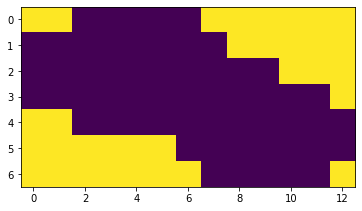

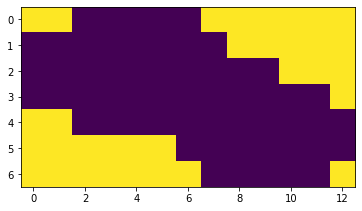

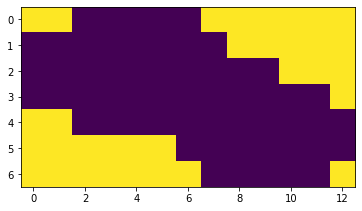

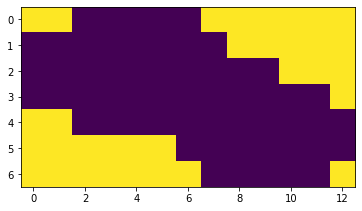

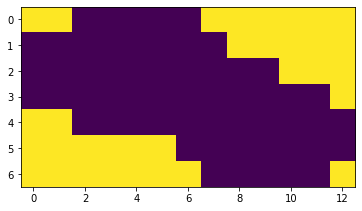

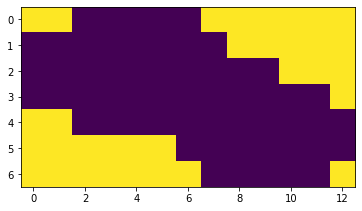

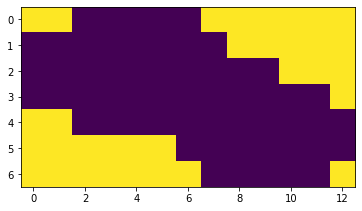

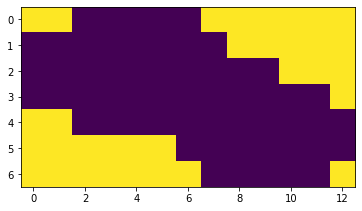

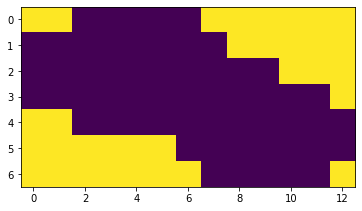

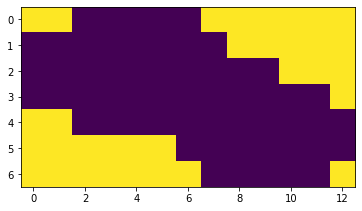

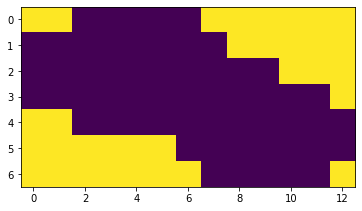

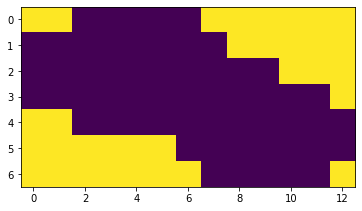

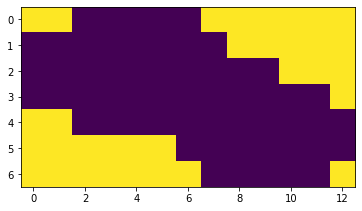

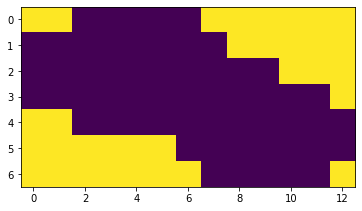

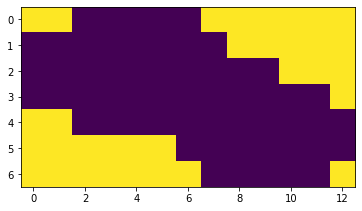

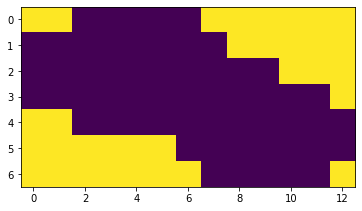

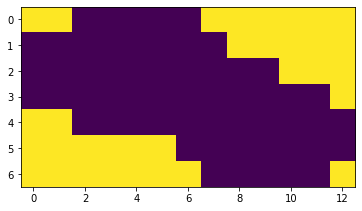

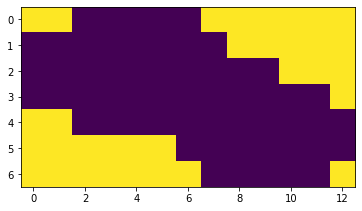

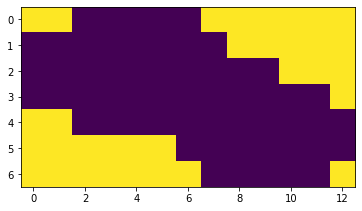

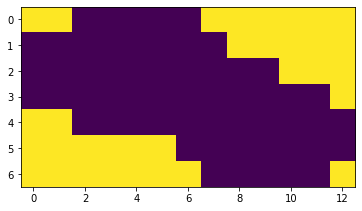

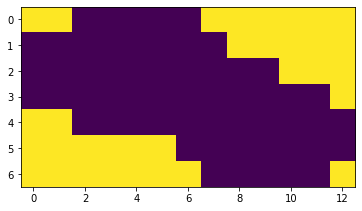

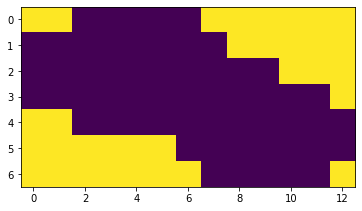

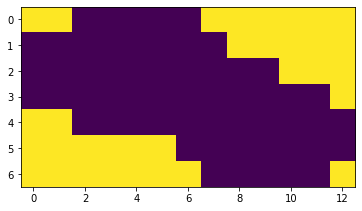

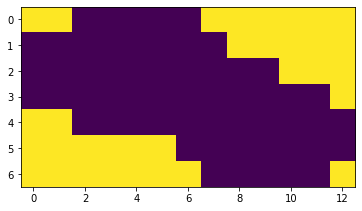

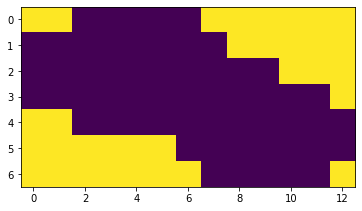

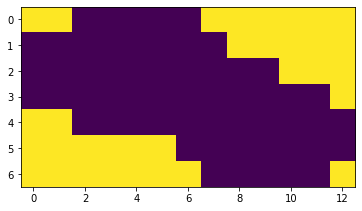

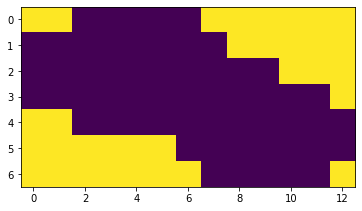

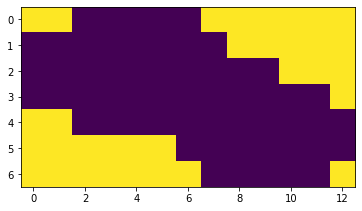

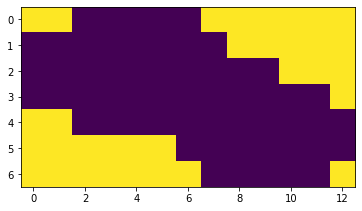

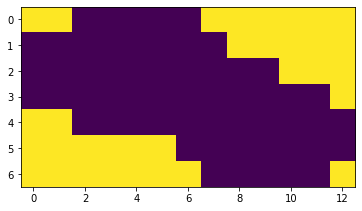

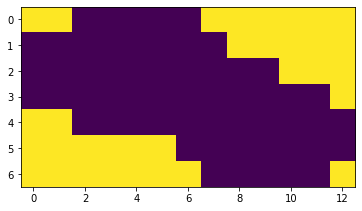

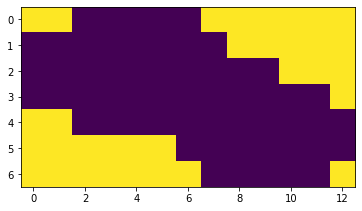

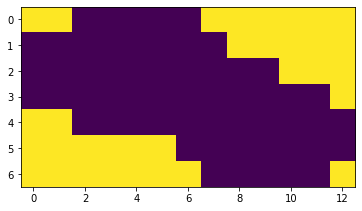

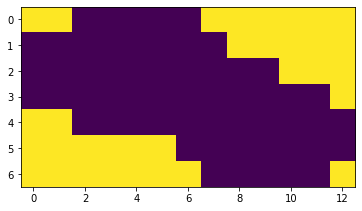

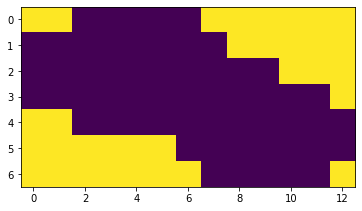

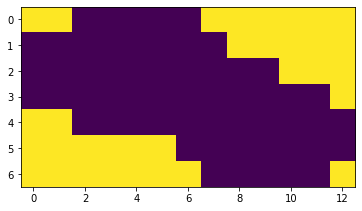

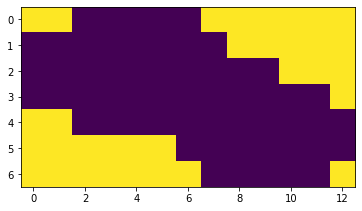

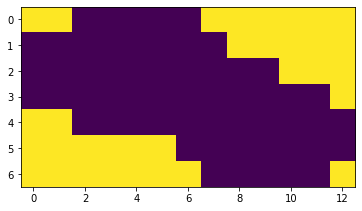

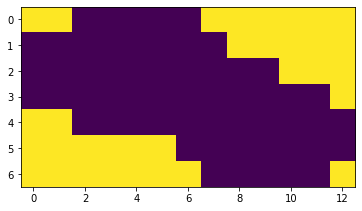

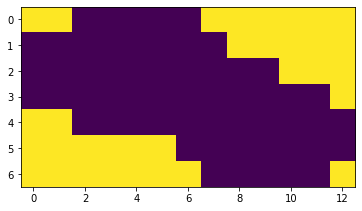

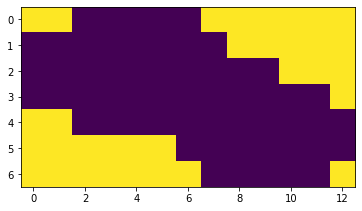

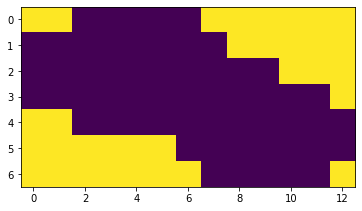

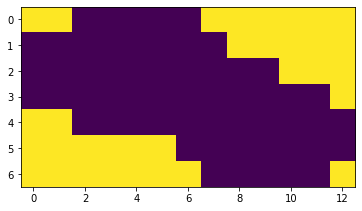

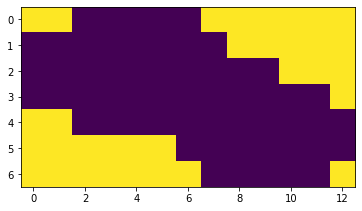

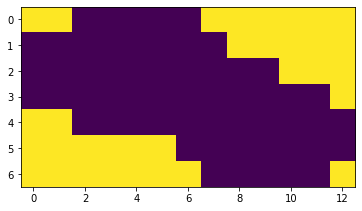

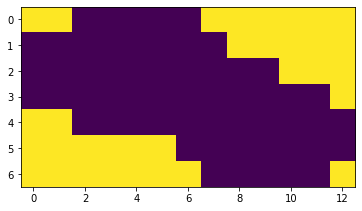

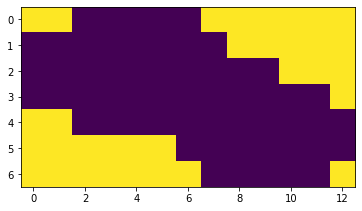

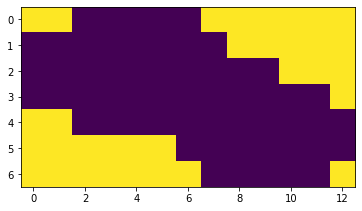

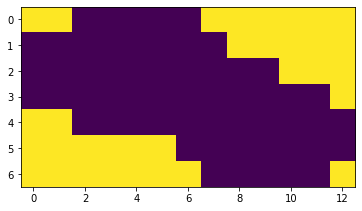

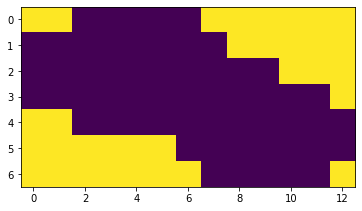

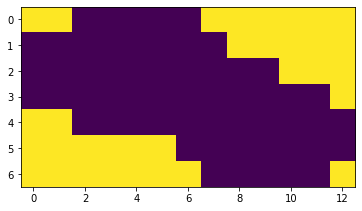

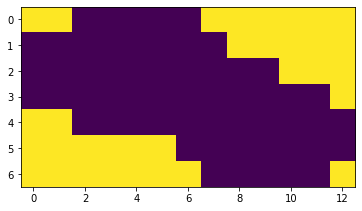

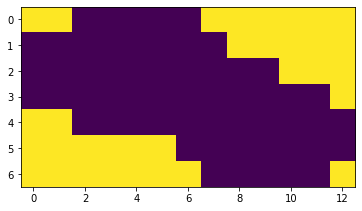

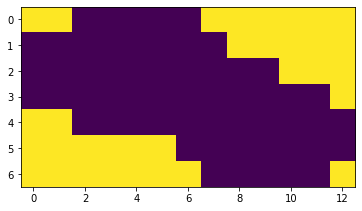

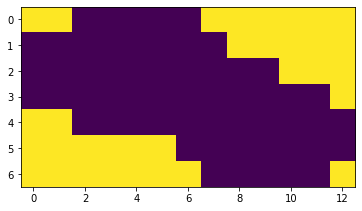

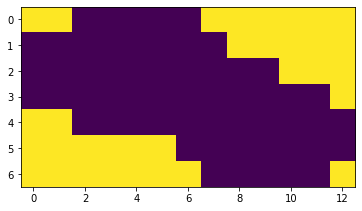

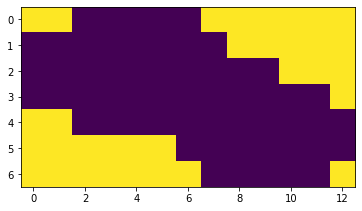

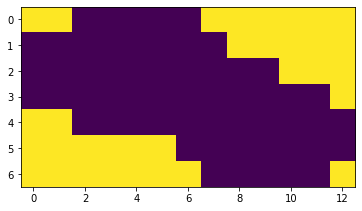

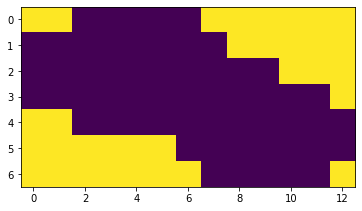

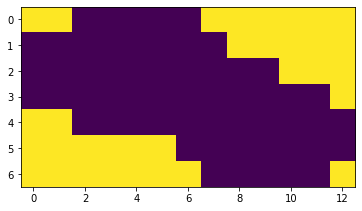

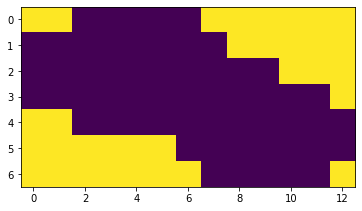

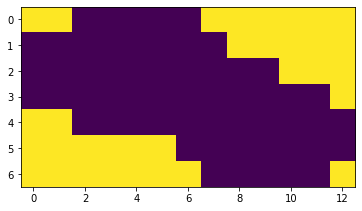

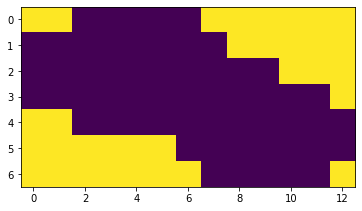

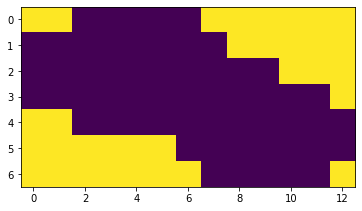

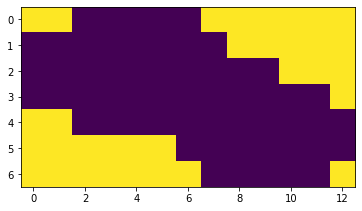

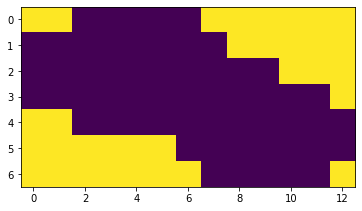

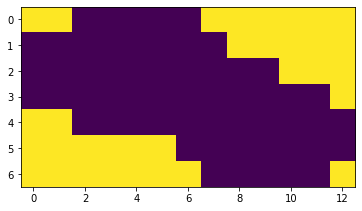

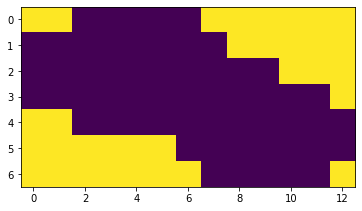

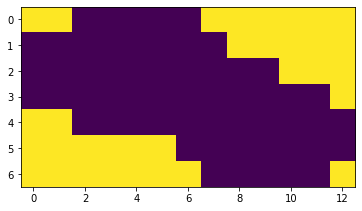

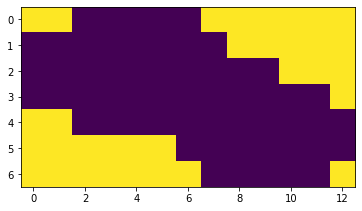

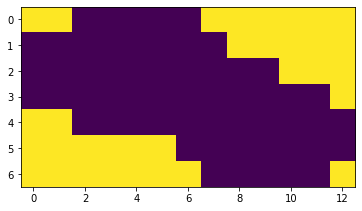

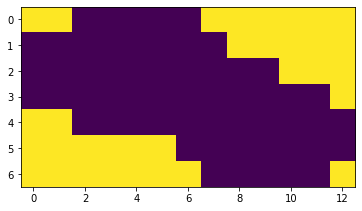

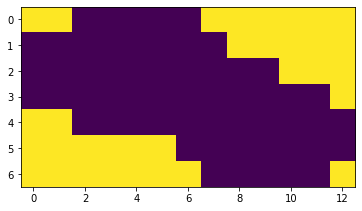

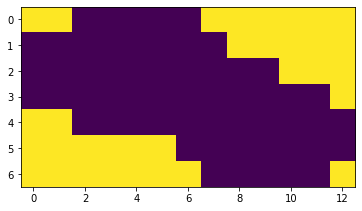

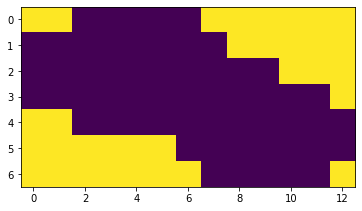

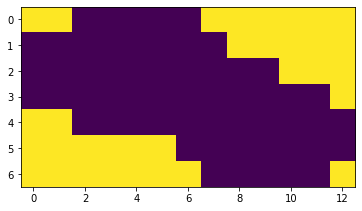

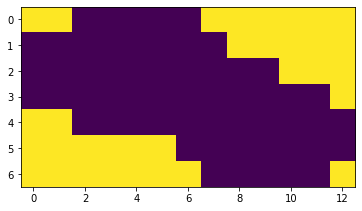

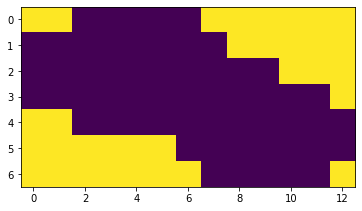

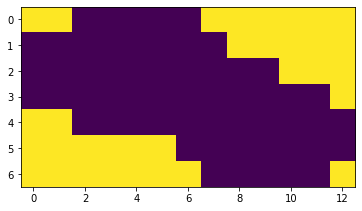

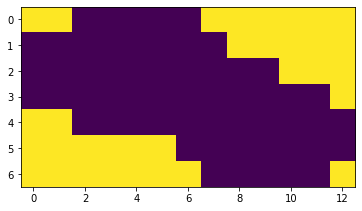

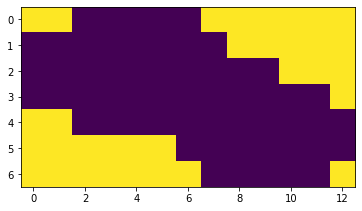

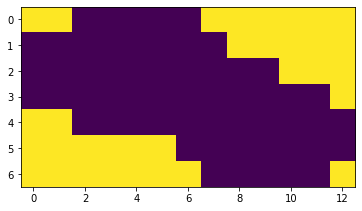

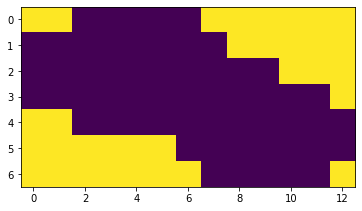

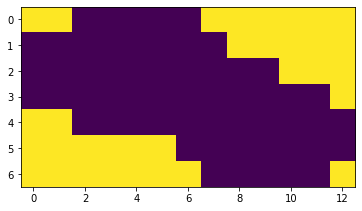

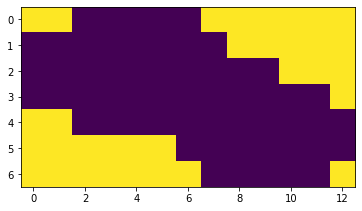

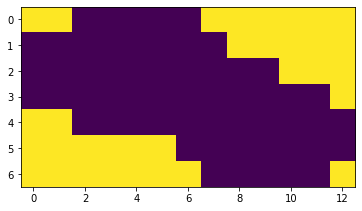

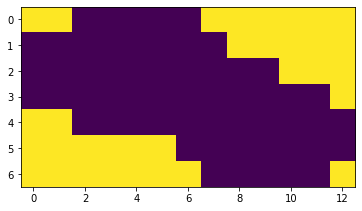

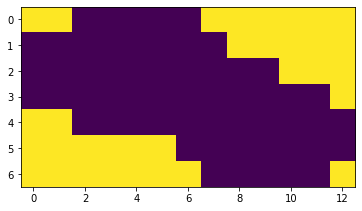

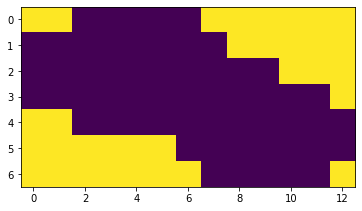

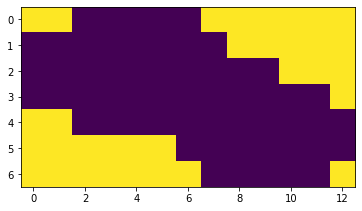

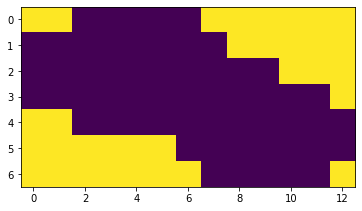

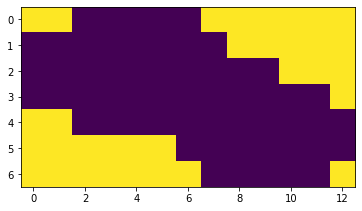

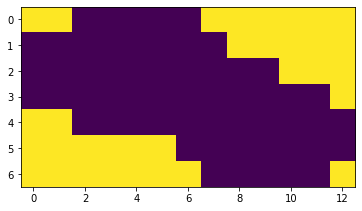

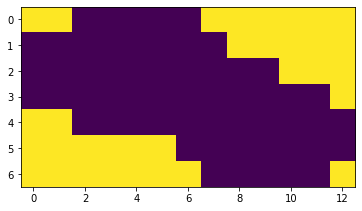

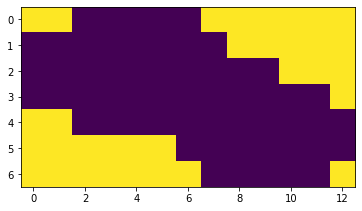

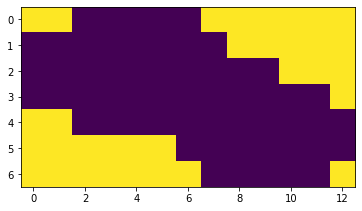

In [112]:
smap_day_root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\SMAP\\SMAP_DAY\\'
output_root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\INPUT\\SMAP\\'
file_extension = '*.tif'

# 使用 glob.glob() 函数获取符合条件的文件列表
files = glob.glob(os.path.join(smap_day_root, file_extension))

# 遍历文件列表
for file in files:
    # 获取文件名（不包含扩展名）
    filename = os.path.basename(file).split('.')[0]
    # 构建输出路径
    output_path = output_root + filename + '\\'
    
    # 将TIFF转换成numpy并保存为MAT文件
    save_tiff_as_numpy(file, output_path, verified_mat)

## 6. Generalize for Label

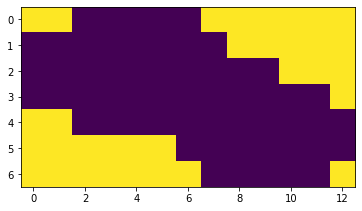

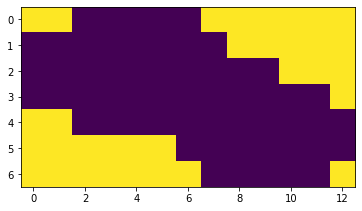

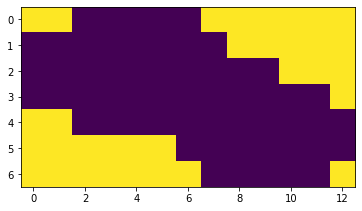

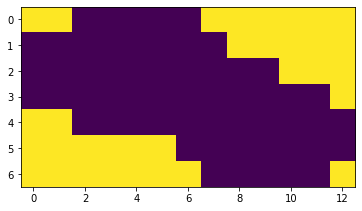

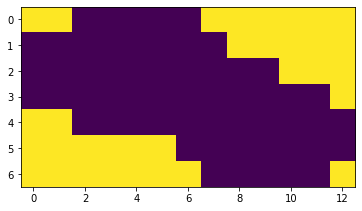

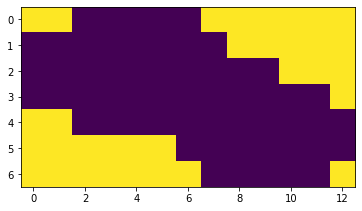

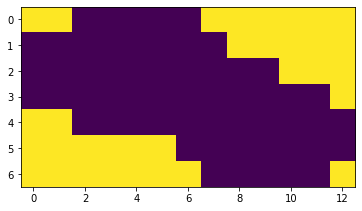

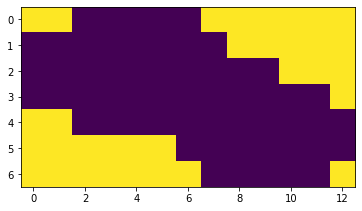

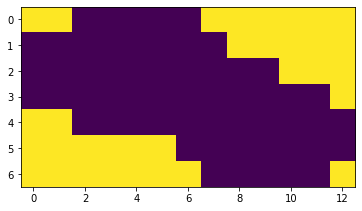

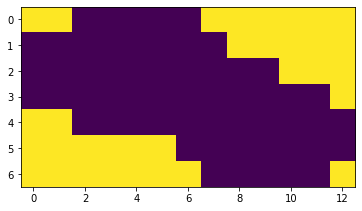

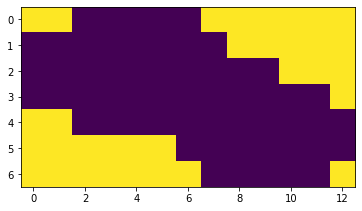

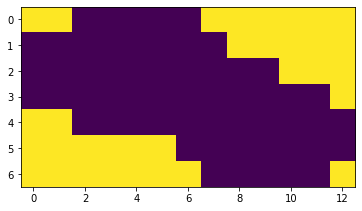

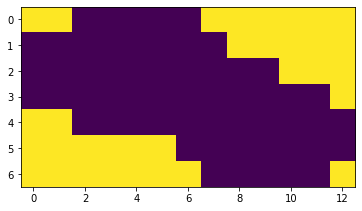

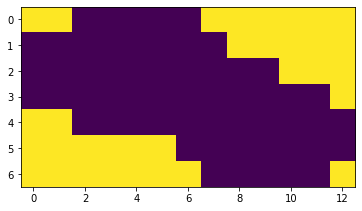

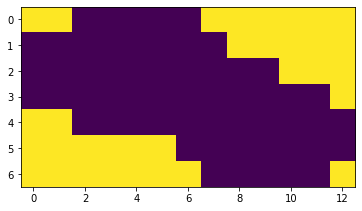

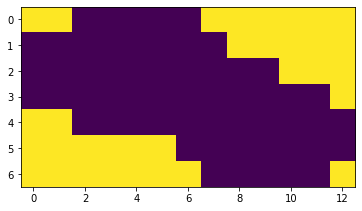

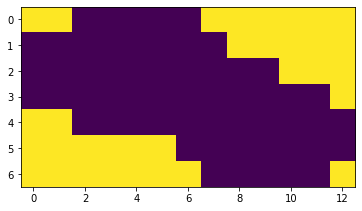

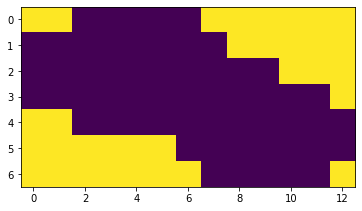

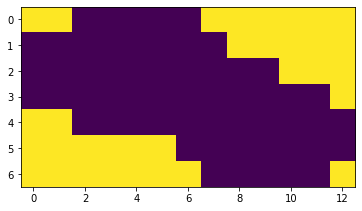

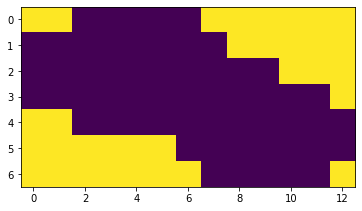

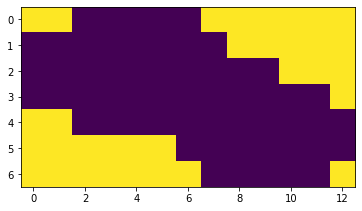

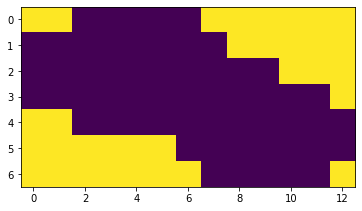

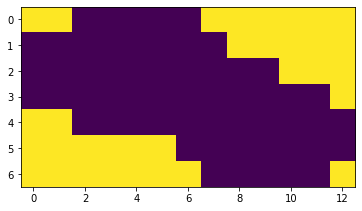

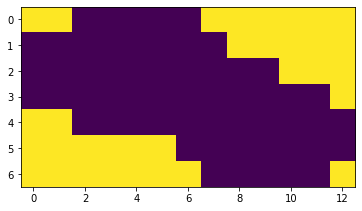

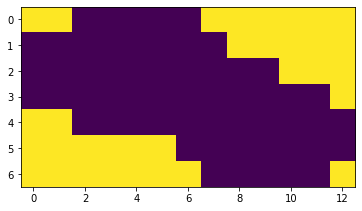

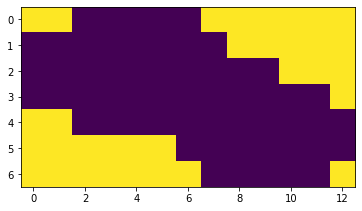

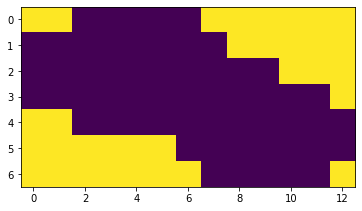

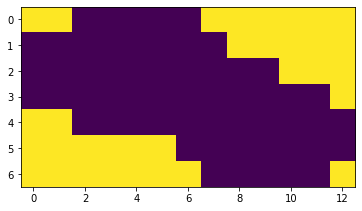

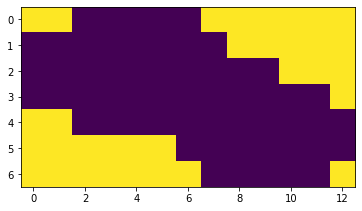

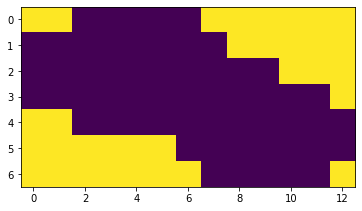

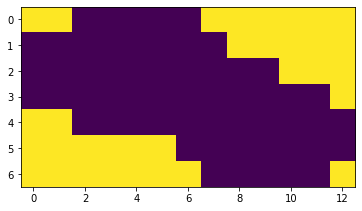

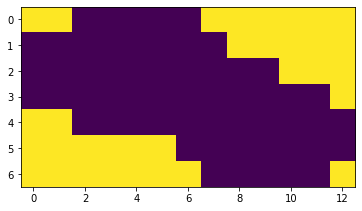

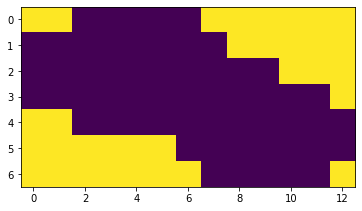

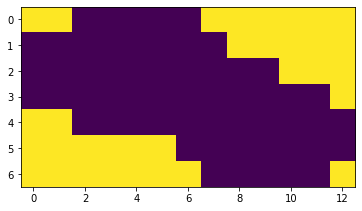

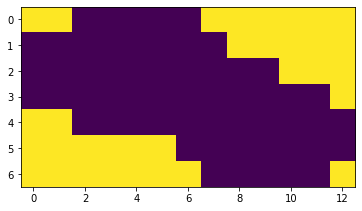

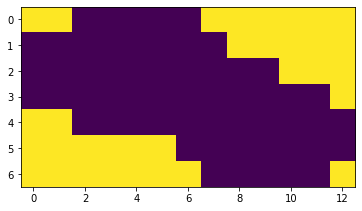

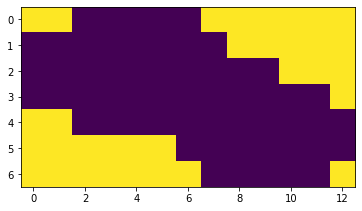

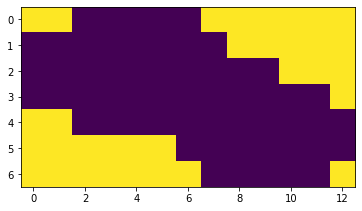

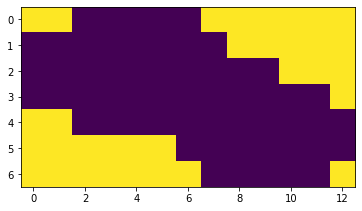

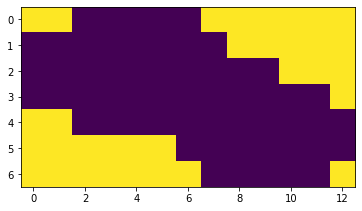

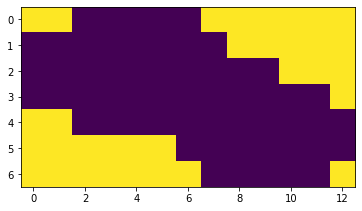

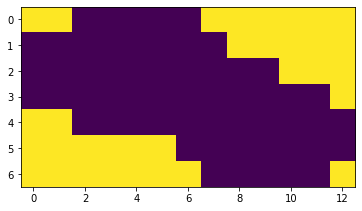

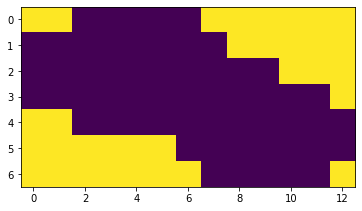

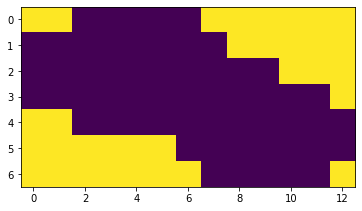

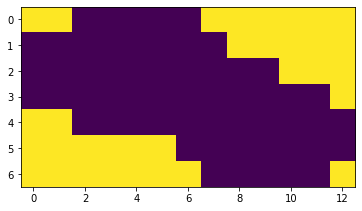

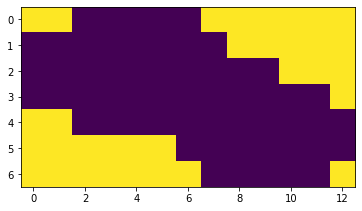

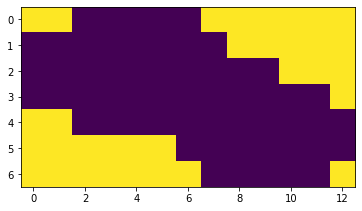

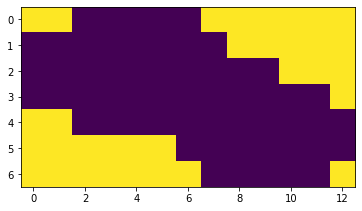

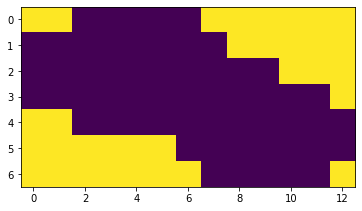

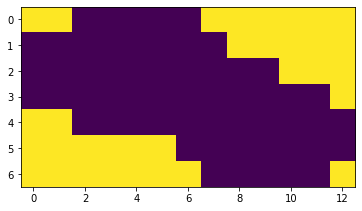

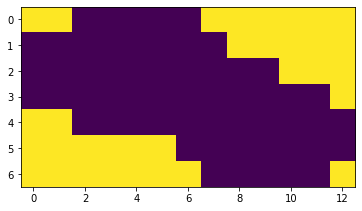

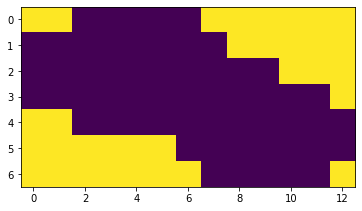

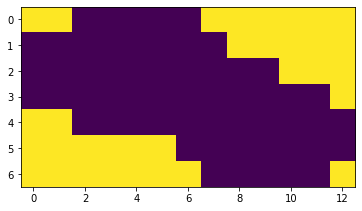

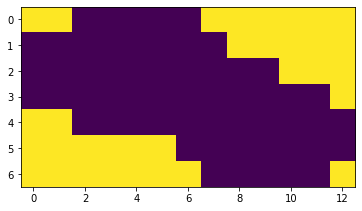

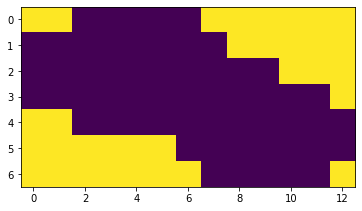

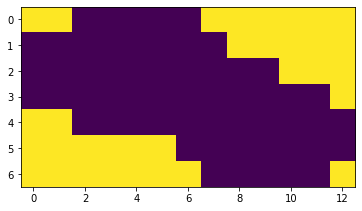

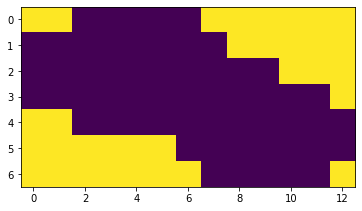

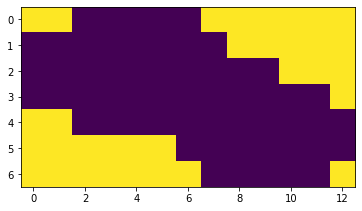

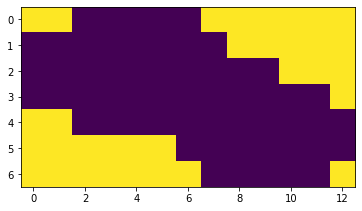

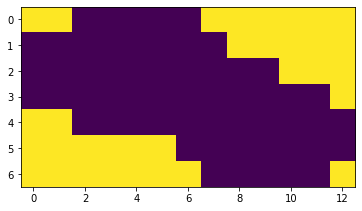

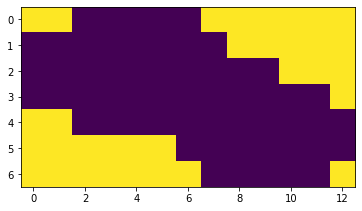

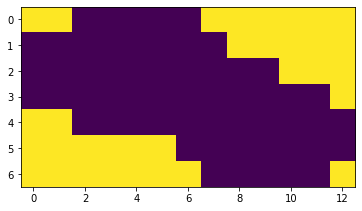

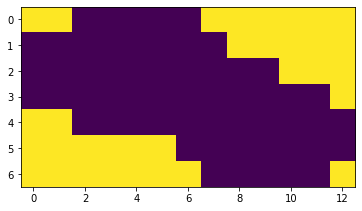

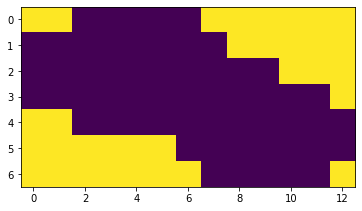

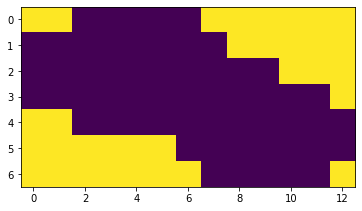

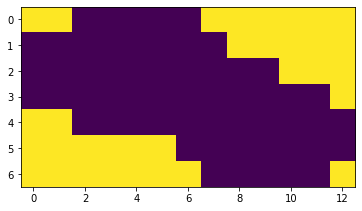

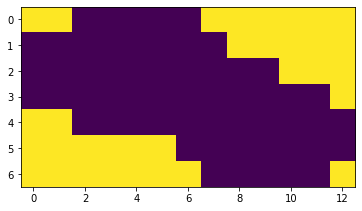

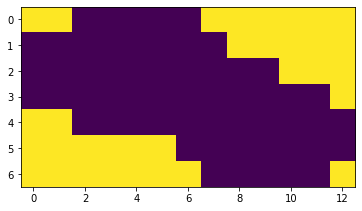

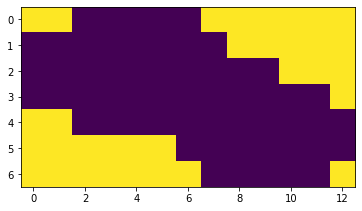

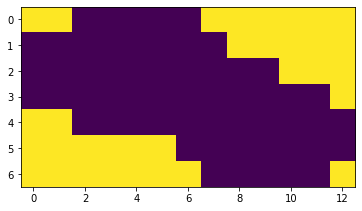

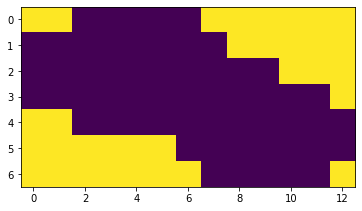

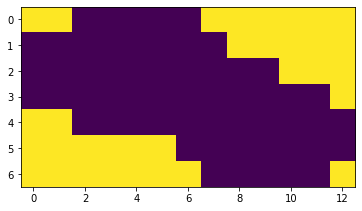

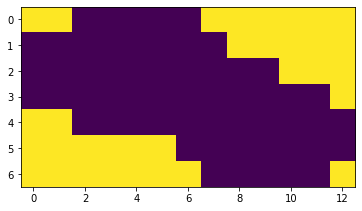

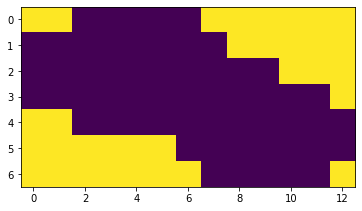

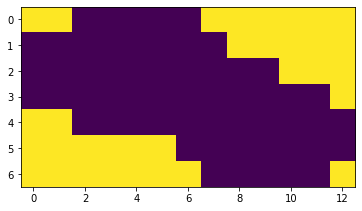

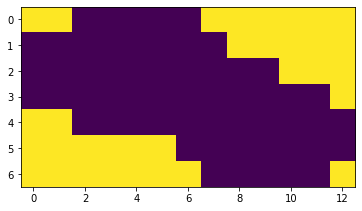

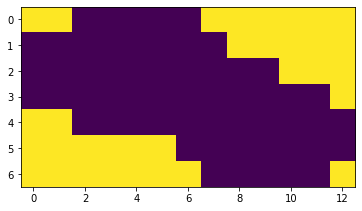

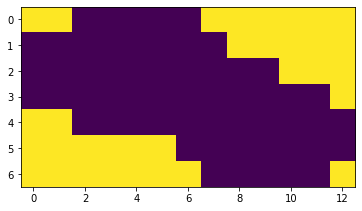

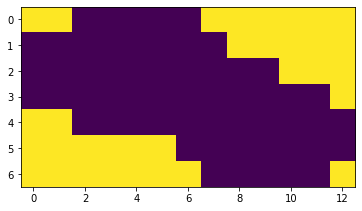

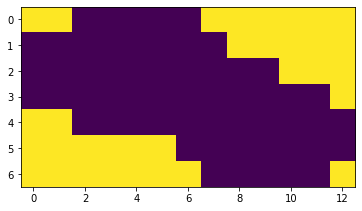

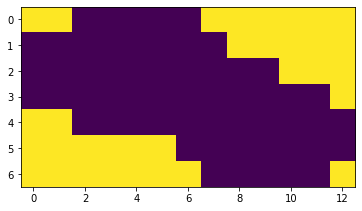

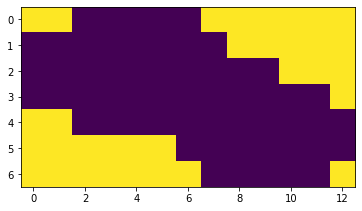

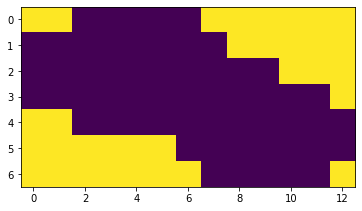

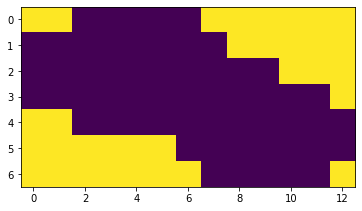

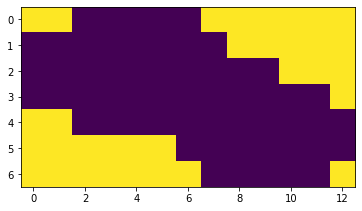

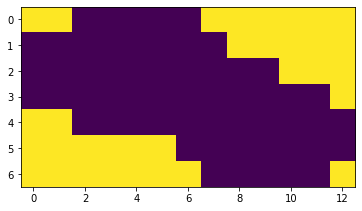

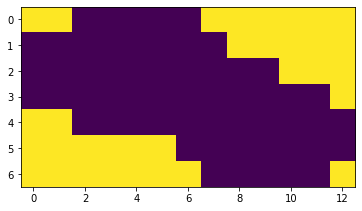

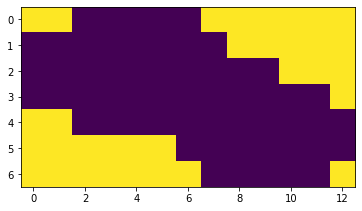

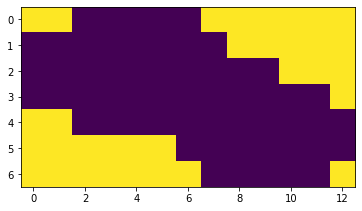

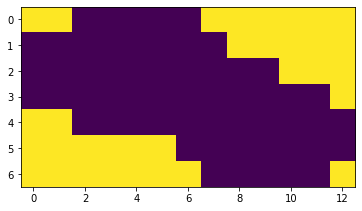

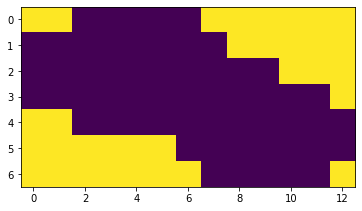

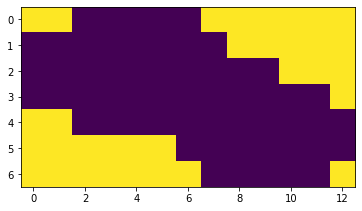

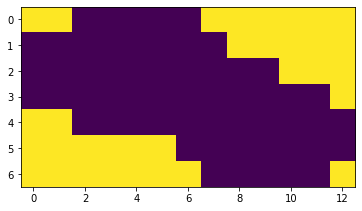

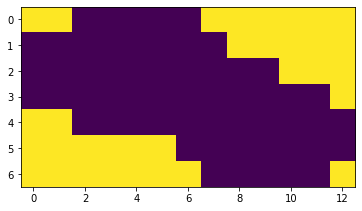

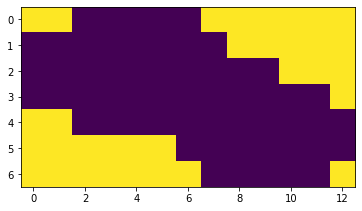

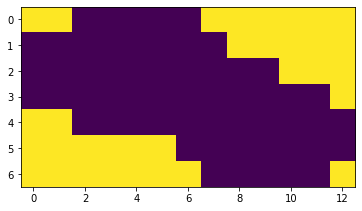

In [113]:
smap_day_root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\SMAP\\SMAP_DAY\\'
output_root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\LABEL\\SMAP\\'
file_extension = '*.tif'

# 使用 glob.glob() 函数获取符合条件的文件列表
files = glob.glob(os.path.join(smap_day_root, file_extension))

# 遍历文件列表
for file in files:
    # 获取文件名（不包含扩展名）
    filename = os.path.basename(file).split('.')[0]
    # 根据文件名构建输出路径
    output_path = output_root + filename + '\\'
    
    # 将TIFF转换成numpy并保存为MAT文件
    save_tiff_as_numpy(file, output_path, verified_mat, False)